In [1]:
#import file dari komputer
from google.colab import files
  
  
uploaded = files.upload()

Saving swear-words.txt to swear-words.txt
Saving sentimentword.csv to sentimentword.csv
Saving positive.tsv to positive.tsv
Saving negative.tsv to negative.tsv
Saving Kamus Normalisasi.xlsx to Kamus Normalisasi.xlsx
Saving dataset.csv to dataset.csv


# Natural Language Processing

## Importing the libraries

In [2]:
pip install swifter

In [3]:
pip install PySastrawi

In [4]:
#pip install googletrans

In [5]:
import pandas as pd
import numpy as np
import pytz
import re
import nltk
import ast
import string
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import io
import pickle, os
#import googletrans   

from datetime import datetime,timedelta
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from nltk.probability import FreqDist
from nltk.stem.porter import PorterStemmer


In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Importing the dataset

In [14]:
dataset = pd.read_csv('dataset.csv')
dataset.drop(['created_at','screen_name'],axis=1,inplace=True)
dataset['Tweet'] = dataset['text']
dataset.shape
dataset['Tweet'].head()



0    @malaibar lolos cpns aku potong kambing, inget...
1                   @adinarasha Sumpah ya dah kea cpns
2    Bismillah, semoga di taun ini lolos cpns, dape...
3                           @nirwandanila Uhuk cpns ya
4    @evaniago Boleh sekalian jawabin soal cpns bua...
Name: Tweet, dtype: object

## Cleaning the texts(Case Folding, Tokenizing, Filtering and Stemming)  

In [17]:
#Case Folding
dataset['Tweet'] = dataset['Tweet'].str.lower()
dataset['Tweet'].shape
print('Hasil Case Folding :')
print(dataset['Tweet'].head(20))

Hasil Case Folding :
0     @malaibar lolos cpns aku potong kambing, inget...
1                    @adinarasha sumpah ya dah kea cpns
2     bismillah, semoga di taun ini lolos cpns, dape...
3                            @nirwandanila uhuk cpns ya
4     @evaniago boleh sekalian jawabin soal cpns bua...
5     "belinya yang mana?"\r\n"yang ini!!"\r\n"lah k...
6                               @terbangkeemg tes cpns?
7                         @ismymufida ngajuin cpns kah?
8                                   @radenrauf tes cpns
9     minwon edisi gagal cute, ya lagian min9yu disu...
10           @collegemenfess bknnya cpns mah ditest ya?
11    setuju banget nih!!\r\n\r\ntak kasih <u+0001f4...
12    ini susah kasusnya. mirip kayak..pihak kampus ...
13    betapa pentingnya baca persyaratan administras...
14    tapi ada jg beberapa yg akhirnya mengundurkan ...
15    dibaca lagi pengumuman pdfnya, bagian persyara...
16    @princepink___ kak lisa mau tes cpns ya? seman...
17    ##. wkwkwkw anjir daf

In [18]:
# ------ Tokenizing ---------

def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")
                
dataset['Tweet'] = dataset['Tweet'].apply(remove_tweet_special)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

dataset['Tweet'] = dataset['Tweet'].apply(remove_number)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

dataset['Tweet'] = dataset['Tweet'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

dataset['Tweet'] = dataset['Tweet'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

dataset['Tweet'] = dataset['Tweet'].apply(remove_whitespace_multiple)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

dataset['Tweet'] = dataset['Tweet'].apply(remove_singl_char)

# NLTK word tokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

dataset['Tweet_tokens'] = dataset['Tweet'].apply(word_tokenize_wrapper)
dataset['Tweet_tokens'].shape
print('Hasil Tokenizing : \n') 
print(dataset['Tweet_tokens'].head(20))
print('\n')
dataset['Tweet_tokens'].to_csv('Tweet Tokenizing.csv')

Hasil Tokenizing : 

0     [lolos, cpns, aku, potong, kambing, ingetin, y...
1                          [sumpah, ya, dah, kea, cpns]
2     [bismillah, semoga, di, taun, ini, lolos, cpns...
3                                      [uhuk, cpns, ya]
4     [boleh, sekalian, jawabin, soal, cpns, buat, a...
5     [belinya, yang, mana, yang, ini, lah, katanya,...
6                                           [tes, cpns]
7                                  [ngajuin, cpns, kah]
8                                           [tes, cpns]
9     [minwon, edisi, gagal, cute, ya, lagian, minyu...
10                      [bknnya, cpns, mah, ditest, ya]
11    [setuju, banget, nih, tak, kasih, ufduffbufduf...
12    [ini, susah, kasusnya, mirip, kayakpihak, kamp...
13    [betapa, pentingnya, baca, persyaratan, admini...
14    [tapi, ada, jg, beberapa, yg, akhirnya, mengun...
15    [dibaca, lagi, pengumuman, pdfnya, bagian, per...
16       [kak, lisa, mau, tes, cpns, ya, semangat, kak]
17    [wkwkwkw, anjir, daft

In [19]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
# Stopword Filtering
# ----------------------- get stopword from NLTK stopword -------------------------------
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')


# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah'])

# ---------------------------------------------------------------------------------------

# convert list to dictionary
list_stopwords = set(list_stopwords)


#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

dataset['Tweet_token_WSW'] = dataset['Tweet_tokens'].apply(stopwords_removal) 

dataset['Tweet_token_WSW'].shape

dataset['Tweet_token_WSW'].to_csv('Tweet Stopword.csv')

print('Hasil Stopword : \n') 

dataset['Tweet_token_WSW'].head(20)



Hasil Stopword : 



0        [lolos, cpns, potong, kambing, ingetin, yaaaa]
1                              [sumpah, dah, kea, cpns]
2     [bismillah, semoga, taun, lolos, cpns, dapet, ...
3                                          [uhuk, cpns]
4                                   [jawabin, cpns, uf]
5     [belinya, toefl, novel, haha, haha, lo, komik,...
6                                           [tes, cpns]
7                                  [ngajuin, cpns, kah]
8                                           [tes, cpns]
9     [minwon, edisi, gagal, cute, minyu, disuruh, g...
10                          [bknnya, cpns, mah, ditest]
11    [setuju, banget, kasih, ufduffbufduffbufduffb,...
12    [susah, kasusnya, kayakpihak, kampus, telat, m...
13    [betapa, baca, persyaratan, administrasi, inst...
14    [jg, mengundurkan, dr, pns, orang, pns, kement...
15    [dibaca, pengumuman, pdfnya, persyaratan, admi...
16                [kak, lisa, tes, cpns, semangat, kak]
17    [wkwkwkw, anjir, daftar, cpns, kak, ufd, g

In [21]:
# Merubah kata slang menjadi normal
normalizad_word = pd.read_excel("Kamus Normalisasi.xlsx")

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

dataset['Tweet_normalized'] = dataset['Tweet_token_WSW'].apply(normalized_term)
dataset['Tweet_normalized'].shape
print('Hasil Mengubah kata Slang: \n') 
dataset['Tweet_normalized'].head(10)

Hasil Mengubah kata Slang: 



0       [lolos, cpns, potong, kambing, ingetin, yaaaa]
1                             [sumpah, dah, kea, cpns]
2    [bismillah, semoga, taun, lolos, cpns, dapet, ...
3                                         [uhuk, cpns]
4                                  [jawabin, cpns, uf]
5    [belinya, toefl, novel, haha, haha, kamu, komi...
6                                          [tes, cpns]
7                                 [ngajuin, cpns, kah]
8                                          [tes, cpns]
9    [minwon, edisi, gagal, cute, minyu, disuruh, g...
Name: Tweet_normalized, dtype: object

In [22]:
# Stemming dataset
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in dataset['Tweet_normalized']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]


dataset['Tweet_tokens_stemmed'] = dataset['Tweet_normalized'].swifter.apply(get_stemmed_term)

dataset.drop(['Tweet','Tweet_token_WSW','Tweet_normalized'],axis=1,inplace=True)

print('Hasil Stemming :','\n')
print(dataset['Tweet_tokens_stemmed'])
dataset.to_csv("Tweet Stemming.csv")

3215
------------------------
lolos : lolos
cpns : cpns
potong : potong
kambing : kambing
ingetin : ingetin
yaaaa : yaaaa
sumpah : sumpah
dah : dah
kea : kea
bismillah : bismillah
semoga : moga
taun : taun
dapet : dapet
jodoh : jodoh
beriman : iman
dewasa : dewasa
gampang : gampang
ngambek : ngambek
stres : stres
tetep : tetep
sehat : sehat
keinginanku : ingin
dikabulkan : kabul
amin : amin
uhuk : uhuk
jawabin : jawabin
uf : uf
belinya : beli
toefl : toefl
novel : novel
haha : haha
kamu : kamu
komik : komik
bang : bang
buku : buku
tes : tes
hr : hr
ngajuin : ngajuin
kah : kah
minwon : minwon
edisi : edisi
gagal : gagal
cute : cute
minyu : minyu
disuruh : suruh
ginianuf : ginianuf
baju : baju
orenuf : orenuf
bknnya : bknnya
mah : mah
ditest : ditest
setuju : tuju
banget : banget
kasih : kasih
ufduffbufduffbufduffb : ufduffbufduffbufduffb
apapun : apa
tema : tema
konferensinya : konferensi
keynote : keynote
speakernya : speakernya
rektor : rektor
pakai : pakai
nada : nada
tagline : tagli

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

Hasil Stemming : 

0         [lolos, cpns, potong, kambing, ingetin, yaaaa]
1                               [sumpah, dah, kea, cpns]
2      [bismillah, moga, taun, lolos, cpns, dapet, jo...
3                                           [uhuk, cpns]
4                                    [jawabin, cpns, uf]
                             ...                        
995    [cpns, anak ingus, tweet, muncul, sanggah, ufu...
996                 [even, pas, test, cpns, pusing, woy]
997             [daftar, cpns, harap, sabar, yaa, umpat]
998                                           [ni, cpns]
999                   [cpns, emang, hokihokian, jem, uf]
Name: Tweet_tokens_stemmed, Length: 1000, dtype: object


In [23]:
# menghilangkan Tweet yang sama
df = pd.read_csv('Tweet Stemming.csv',index_col=0)

print ("Menghilangkan Tweet yang sama :")
print ("sebelum " ,len(df))
df.drop_duplicates(subset = 'Tweet_tokens_stemmed', 
                                    keep = 'first', 
                                    inplace = True)

df.drop(['Tweet_tokens'],axis=1,inplace=True)

print ("sesudah " ,len(df))

df.to_csv("Tweet Bersih.csv")

df['Tweet_tokens_stemmed'].head(30)


Menghilangkan Tweet yang sama :
sebelum  1000
sesudah  885


0     ['lolos', 'cpns', 'potong', 'kambing', 'ingeti...
1                      ['sumpah', 'dah', 'kea', 'cpns']
2     ['bismillah', 'moga', 'taun', 'lolos', 'cpns',...
3                                      ['uhuk', 'cpns']
4                             ['jawabin', 'cpns', 'uf']
5     ['beli', 'toefl', 'novel', 'haha', 'haha', 'ka...
6                                       ['tes', 'cpns']
7                            ['ngajuin', 'cpns', 'kah']
9     ['minwon', 'edisi', 'gagal', 'cute', 'minyu', ...
10                  ['bknnya', 'cpns', 'mah', 'ditest']
11    ['tuju', 'banget', 'kasih', 'ufduffbufduffbufd...
12    ['susah', 'kasus', 'kayakpihak', 'kampus', 'te...
13    ['betapa', 'baca', 'syarat', 'administrasi', '...
14    ['juga', 'undur', 'dari', 'pns', 'orang', 'pns...
15    ['baca', 'umum', 'pdfnya', 'syarat', 'administ...
16    ['kak', 'lisa', 'tes', 'cpns', 'semangat', 'kak']
17    ['wkwkwkw', 'waw', 'daftar', 'cpns', 'kak', 'u...
18            ['sodnya', 'bray', 'kaya', 'tkp', 

In [24]:
#Pembersihan data yang kosong
df = pd.read_csv('Tweet Bersih.csv')

len(df[df['Tweet_tokens_stemmed'].isnull()==True])
df = df.dropna(subset=['Tweet_tokens_stemmed'])
def count_words(x):
    words = word_tokenize(x)
    n=len(words)
    return n

df['word_length'] = df['Tweet_tokens_stemmed'].apply(lambda x:count_words(x))
df['word_length'].value_counts().sort_index()

4       2
7      28
10     61
13     75
16     81
17      3
18      1
19     83
20      1
22     57
23      1
25     62
26      2
28     58
29      2
31     39
32      2
34     38
35      8
37     34
38      3
40     25
41      4
43     25
44      4
46     16
47      1
49     10
50      1
52     21
53      2
55      8
56      3
57      1
58      7
61      8
63      1
64     14
65      1
67     14
68      2
70     10
73     13
74      1
76     12
77      3
79      8
82      8
84      1
85      4
86      1
88      6
91      1
92      1
94      2
98      1
100     1
103     1
106     1
108     1
Name: word_length, dtype: int64

Mereset Index

In [25]:
df = df.drop(df[df['word_length']==0].index,axis=0)
df = df.reset_index(drop=True)
df['Tweet_tokens_stemmed'].head(30)

0     ['lolos', 'cpns', 'potong', 'kambing', 'ingeti...
1                      ['sumpah', 'dah', 'kea', 'cpns']
2     ['bismillah', 'moga', 'taun', 'lolos', 'cpns',...
3                                      ['uhuk', 'cpns']
4                             ['jawabin', 'cpns', 'uf']
5     ['beli', 'toefl', 'novel', 'haha', 'haha', 'ka...
6                                       ['tes', 'cpns']
7                            ['ngajuin', 'cpns', 'kah']
8     ['minwon', 'edisi', 'gagal', 'cute', 'minyu', ...
9                   ['bknnya', 'cpns', 'mah', 'ditest']
10    ['tuju', 'banget', 'kasih', 'ufduffbufduffbufd...
11    ['susah', 'kasus', 'kayakpihak', 'kampus', 'te...
12    ['betapa', 'baca', 'syarat', 'administrasi', '...
13    ['juga', 'undur', 'dari', 'pns', 'orang', 'pns...
14    ['baca', 'umum', 'pdfnya', 'syarat', 'administ...
15    ['kak', 'lisa', 'tes', 'cpns', 'semangat', 'kak']
16    ['wkwkwkw', 'waw', 'daftar', 'cpns', 'kak', 'u...
17            ['sodnya', 'bray', 'kaya', 'tkp', 

In [26]:
#Membuat kamus data dari dataset
word_dict = {}
for i in range(0,len(df['Tweet_tokens_stemmed'])):
    sentence = df['Tweet_tokens_stemmed'][i]
    word_token = word_tokenize(sentence)
    for j in word_token:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [27]:
len(word_dict)


2797

In [28]:
len({k:v for (k,v) in word_dict.items() if v < 4})

2324

# Analisis

## Data Labeling

sources : <br>
https://github.com/louisowen6/NLP_bahasa_resources <br>
https://github.com/abhimantramb/elang/blob/master/word2vec/utils/swear-words.txt <br>
https://github.com/fajri91/InSet <br>
https://github.com/agusmakmun/SentiStrengthID/blob/master/id_dict/sentimentword.txt 

import kamus

In [29]:
pos_lexicon = pd.read_csv('positive.tsv',sep='\t')
neg_lexicon = pd.read_csv('negative.tsv',sep='\t')

In [30]:
lexicon = pos_lexicon.append(neg_lexicon,ignore_index=True)
len(lexicon)

10218

In [31]:
addition = pd.read_csv('sentimentword.csv')
addition

,word,weight
0,abadi,2
1,absen,-2
2,abu-abu,-2
3,acuh,-1
4,adil,2
...,...,...
1568,waspadalah,-2
1569,wow,3
1570,wtf,-3
1571,yakin,1


In [32]:
addition.isnull().sum()

word      0
weight    0
dtype: int64

In [33]:
lexicon.isnull().sum()

word      0
weight    0
dtype: int64

In [34]:
lexicon_word = lexicon['word'].to_list()

In [35]:
lexicon['word'][0] in lexicon_word

True

In [36]:
add_word = []
add_weight = []
for i in range(0,len(addition)):
    if (addition['word'][i] not in lexicon_word):
        add_word.append(addition['word'][i])
        add_weight.append(addition['weight'][i])

addition_lexicon = pd.DataFrame(list(zip(add_word,add_weight)),columns =['word','weight'])
addition_lexicon

,word,weight
0,acuh,-1
1,agresi,-3
2,ajaib,3
3,akal,2
4,alarm,-3
...,...,...
821,waktunya,-2
822,waspadalah,-2
823,wow,3
824,wtf,-3


In [37]:
full_lexicon = lexicon.append(addition_lexicon,ignore_index = True)
full_lexicon.tail(5)

,word,weight
11039,waktunya,-2
11040,waspadalah,-2
11041,wow,3
11042,wtf,-3
11043,yatim,-2


In [38]:
full_lexicon[full_lexicon['weight']>0].min()

word      (hujan) gerimis
weight                  1
dtype: object

In [39]:
my_file = open("swear-words.txt", "r")
content = my_file.read()
swear_words = content.split("\n")

In [40]:
weight_swear = [-5 for i in range(len(swear_words))]

In [41]:
swear_lexicon = pd.DataFrame(list(zip(swear_words,weight_swear)),columns =['word','weight'])

In [42]:
swear_lexicon

,word,weight
0,anjing,-5
1,anjiang,-5
2,anjir,-5
3,anjay,-5
4,asu,-5
...,...,...
57,sontoloyo,-5
58,tai,-5
59,telek,-5
60,tolol,-5


In [43]:
full_lexicon = lexicon.append(swear_lexicon,ignore_index = True)

In [44]:
len(full_lexicon)

10280

In [45]:
full_lexicon.shape

full_lexicon


,word,weight
0,hai,3
1,merekam,2
2,ekstensif,3
3,paripurna,1
4,detail,2
...,...,...
10275,sontoloyo,-5
10276,tai,-5
10277,telek,-5
10278,tolol,-5


In [46]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [47]:
def number_of_words(x):
    words = word_tokenize(x['word'])
    number = len(words)
    return number

full_lexicon['number_of_words'] = full_lexicon.apply(lambda x: number_of_words(x),axis=1)
full_lexicon = full_lexicon.drop(full_lexicon[full_lexicon['number_of_words'] == 1].index[0],axis=0)
full_lexicon  = full_lexicon.reset_index(drop=True)
full_lexicon[full_lexicon['number_of_words'] == 3]

,word,weight,number_of_words
116,jalan bebas hambatan,2,3
363,asah asih asuh,2,3
573,lunas (kapal,2,3
1105,mencium telapak kaki,1,3
1500,naik ke pelaminan,3,3
1852,naik ke pelamin,3,3
1870,cium telapak kaki,1,3
1903,minta kpd tuhan,3,3
1926,jalan bebas hambat,2,3
2072,acuh tak acuh,4,3


In [48]:
full_lexicon['number_of_words'] = full_lexicon.apply(lambda x: number_of_words(x),axis=1)

In [49]:
full_lexicon = full_lexicon.drop(full_lexicon[full_lexicon['number_of_words'] == 1].index[0],axis=0)


In [50]:
full_lexicon  = full_lexicon.reset_index(drop=True)


In [51]:
full_lexicon[full_lexicon['number_of_words'] == 3]


,word,weight,number_of_words
115,jalan bebas hambatan,2,3
362,asah asih asuh,2,3
572,lunas (kapal,2,3
1104,mencium telapak kaki,1,3
1499,naik ke pelaminan,3,3
1851,naik ke pelamin,3,3
1869,cium telapak kaki,1,3
1902,minta kpd tuhan,3,3
1925,jalan bebas hambat,2,3
2071,acuh tak acuh,4,3


In [52]:
full_lexicon.to_csv(r'full_lexicon.csv',index=False)

In [53]:
len(full_lexicon)

10278

In [54]:
modified_lexicon = pd.read_csv('full_lexicon.csv')

In [55]:
modified_lexicon['number_of_words'] = modified_lexicon.apply(lambda x: number_of_words(x),axis=1)

In [56]:
modified_lexicon.to_csv(r'modified_full_lexicon.csv',index=False)

In [57]:
# menghapus kata negasi
negasi = ['bukan','tidak','ga','gk']
lexicon = pd.read_csv('modified_full_lexicon.csv')
lexicon = lexicon.drop(lexicon[(lexicon['word'] == 'bukan')
                              |(lexicon['word'] == 'tidak')
                              |(lexicon['word'] == 'ga')|(lexicon['word'] == 'gk') ].index,axis=0)
lexicon = lexicon.reset_index(drop=True)


In [58]:
len(lexicon)

10276

In [59]:
lexicon.head(10)


,word,weight,number_of_words
0,ekstensif,3,1
1,paripurna,1,1
2,detail,2,1
3,pernik,3,1
4,belas,2,1
5,welas,4,1
6,kabung,1,1
7,rahayu,4,1
8,maaf,2,1
9,hello,2,1


In [60]:
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

In [61]:
len(lexicon_word)

10276

Checking if there is words in dictionary that does not included in the lexicon

In [62]:
ns_words = []
factory = StemmerFactory()
stemmer = factory.create_stemmer()
for word in word_dict.keys():
    if word not in lexicon_word:
        kata_dasar = stemmer.stem(word)
        if kata_dasar not in lexicon_word:
            ns_words.append(word)
len(ns_words)

2040

Let's take a look what kind of words they are, lets start with some words that have many occurences as this most likely not a type case

In [63]:
len({k:v for (k,v) in word_dict.items() if ((k in ns_words)&(v>3)) })

255

In [64]:
ns_words_list = {k:v for (k,v) in word_dict.items() if ((k in ns_words)&(v>3))}

It turns out that the words that is not included in lexicon, are the one that not have signifance sentiment

In [65]:
#sort_orders = sorted(ns_words_list.items(), key=lambda x: x[1], reverse=True)
#sort_orders=sort_orders[0:20]
#for i in sort_orders:
#   print(i[0], i[1])

In [66]:
#word_to_plot = df['Tweet_tokens'].copy()


creating word cloud to see what kind of words that appear often in the tweets related to the pandemic

In [67]:
#word_to_plot_1 = word_to_plot.apply(lambda x: del_word(x,negasi))


In [68]:
#wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', max_words = 1000
#                     , min_font_size = 20).generate(str(word_to_plot_1))
#plot the word cloud
#fig = plt.figure(figsize = (8,8), facecolor = None)
#plt.imshow(wordcloud)
#plt.axis('off')
#plt.show()

Sentiment

In [69]:
lexicon['number_of_words'].value_counts()

1    9536
2     684
3      26
4      25
5       5
Name: number_of_words, dtype: int64

In [70]:
'pekerti' in word_dict

False

In [71]:
'baik' in lexicon_word

True

In [72]:
sencol =[]
senrow =np.array([])
nsen = 0
factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentiment_list = []
# function to write the word's sentiment if it is founded
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # if it is already included in the bag of words matrix, then just increase the value
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    #if not, than add new word
        sencol.append(word)
        sen.append(1)
        add += 1
    #if there is a negation word before it, the sentiment would be the negation of it's sentiment
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add
            
# checking every words, if they are appear in the lexicon, and then calculate their sentiment if they do
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['Tweet_tokens_stemmed'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # check whether they are included in the lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # if not, then check the root word
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # if still negative, try to match the combination of words with the adjacent words
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [73]:
len(sentiment_list)

885

In [74]:
print(senrow.shape[0])

885


In [75]:
sencol.append('sentiment')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

In [76]:
df_sen

,lolos,potong,kambing,ingetin,yaaaa,sumpah,dah,bismillah,moga,taun,dapet,jodoh,iman,dewasa,gampang,ngambek,stres,sehat,amin,beli,novel,gagal,cute,suruh,baju,tuju,banget,kasih,apa,konferensi,nada,teh,susah,telat,panjang,akreditasi,lulus,habis,betapa,baca,...,cacat,nyesel,sepatu,bokek,xx,jreng,mules,pecat,bocor,kembar,definisi,tekad,kuat,yakin,wujud,begadang,lam,malem,direktur,jelata,akut,narkotika,denda,apes,adek,familiar,kiat,tara,cuma,jatuh,ngarep,seru,pergi,kasihan,sangka,masak,nakal,konco,jatah,sentiment
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-10
1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,1,1,1,1,1,1,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-2
881,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
882,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
883,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [77]:
# melihat sentimen dari tweet original

cek_df = pd.DataFrame([])
cek_df['tweet'] = df['Tweet_tokens_stemmed'].copy()
cek_df['bobot']  = df_sen['sentiment'].copy()

In [78]:
cek_df.head(20)

,tweet,bobot
0,"['lolos', 'cpns', 'potong', 'kambing', 'ingeti...",-10
1,"['sumpah', 'dah', 'kea', 'cpns']",0
2,"['bismillah', 'moga', 'taun', 'lolos', 'cpns',...",12
3,"['uhuk', 'cpns']",0
4,"['jawabin', 'cpns', 'uf']",0
5,"['beli', 'toefl', 'novel', 'haha', 'haha', 'ka...",4
6,"['tes', 'cpns']",0
7,"['ngajuin', 'cpns', 'kah']",0
8,"['minwon', 'edisi', 'gagal', 'cute', 'minyu', ...",1
9,"['bknnya', 'cpns', 'mah', 'ditest']",0


In [79]:
#create a list of our conditions
conditions = [
    (cek_df['bobot'] > 0),
    (cek_df['bobot'] == 0),
    (cek_df['bobot'] < 0)
    
    ]

# create a list of the values we want to assign for each condition
values = ['positif', 'netral','negatif']

# create a new column and use np.select to assign values to it using our lists as arguments
cek_df['sentimen'] = np.select(conditions, values)

In [80]:
# display updated DataFrame
cek_df

,tweet,bobot,sentimen
0,"['lolos', 'cpns', 'potong', 'kambing', 'ingeti...",-10,negatif
1,"['sumpah', 'dah', 'kea', 'cpns']",0,netral
2,"['bismillah', 'moga', 'taun', 'lolos', 'cpns',...",12,positif
3,"['uhuk', 'cpns']",0,netral
4,"['jawabin', 'cpns', 'uf']",0,netral
...,...,...,...
880,"['cpns', 'anak ingus', 'tweet', 'muncul', 'san...",-2,negatif
881,"['even', 'pas', 'test', 'cpns', 'pusing', 'woy']",-1,negatif
882,"['daftar', 'cpns', 'harap', 'sabar', 'yaa', 'u...",5,positif
883,"['ni', 'cpns']",0,netral


In [81]:
cek_df.to_csv("Tweet Label.csv")

In [82]:
df = pd.read_csv('Tweet Label.csv')

In [83]:
df

,Unnamed: 0,tweet,bobot,sentimen
0,0,"['lolos', 'cpns', 'potong', 'kambing', 'ingeti...",-10,negatif
1,1,"['sumpah', 'dah', 'kea', 'cpns']",0,netral
2,2,"['bismillah', 'moga', 'taun', 'lolos', 'cpns',...",12,positif
3,3,"['uhuk', 'cpns']",0,netral
4,4,"['jawabin', 'cpns', 'uf']",0,netral
...,...,...,...,...
880,880,"['cpns', 'anak ingus', 'tweet', 'muncul', 'san...",-2,negatif
881,881,"['even', 'pas', 'test', 'cpns', 'pusing', 'woy']",-1,negatif
882,882,"['daftar', 'cpns', 'harap', 'sabar', 'yaa', 'u...",5,positif
883,883,"['ni', 'cpns']",0,netral


In [84]:
#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

df['tweet'] = df['tweet'].apply(remove_punctuation)


df.drop(['Unnamed: 0'],axis=1,inplace=True)

df.head()


,tweet,bobot,sentimen
0,lolos cpns potong kambing ingetin yaaaa,-10,negatif
1,sumpah dah kea cpns,0,netral
2,bismillah moga taun lolos cpns dapet jodoh ima...,12,positif
3,uhuk cpns,0,netral
4,jawabin cpns uf,0,netral


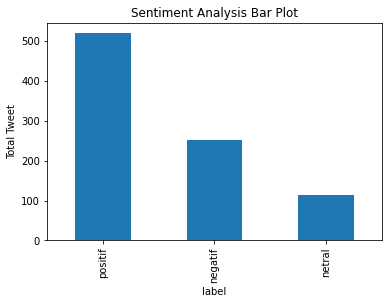

In [85]:
df['sentimen'].value_counts().plot(kind='bar')
plt.title('Sentiment Analysis Bar Plot')
plt.xlabel('label')
plt.ylabel('Total Tweet')
plt.show()

In [86]:
pos = df[df['sentimen'] == 'positif']
pos = pos['tweet']
print('Total tweet positif ', round( ( pos.shape[0] / df.shape[0] ) *100, 1),'%')
pos = (pos.shape[0] / df.shape[0]) *100


Total tweet positif  58.6 %


In [87]:
neg = df[df['sentimen'] == 'negatif']
neg = neg['tweet']
print('Total tweet negatif ', round( ( neg.shape[0] / df.shape[0] ) *100, 1),'%')
neg = (neg.shape[0] / df.shape[0]) *100

Total tweet negatif  28.4 %


In [88]:
net = df[df['sentimen'] == 'netral']
net = net['tweet']
print('Total tweet netral ', round( ( net.shape[0] / df.shape[0] ) *100, 1),'%')
net = (net.shape[0] / df.shape[0]) *100

Total tweet netral  13.0 %


In [89]:
df.head(30)

,tweet,bobot,sentimen
0,lolos cpns potong kambing ingetin yaaaa,-10,negatif
1,sumpah dah kea cpns,0,netral
2,bismillah moga taun lolos cpns dapet jodoh ima...,12,positif
3,uhuk cpns,0,netral
4,jawabin cpns uf,0,netral
5,beli toefl novel haha haha kamu komik bang buk...,4,positif
6,tes cpns,0,netral
7,ngajuin cpns kah,0,netral
8,minwon edisi gagal cute minyu suruh ginianuf u...,1,positif
9,bknnya cpns mah ditest,0,netral


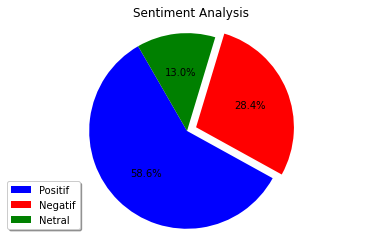

In [90]:
explode = (0,0.1,0)  
labels = 'Positif', "Negatif", "Netral"
sizes = [pos,neg,net]
colors = ['Blue','Red','Green']

plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', startangle=120)
plt.legend(labels,loc=[-0.05,0.05], shadow = True)
plt.axis('equal')
plt.title("Sentiment Analysis")
plt.show()

In [91]:
text = " ".join(review for review in df.tweet)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 56711 words in the combination of all review.


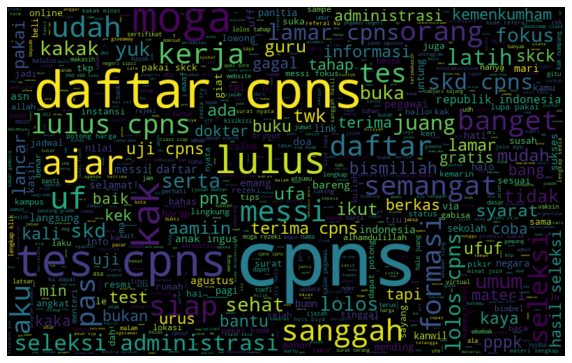

In [92]:
all_word =  ' '.join(text for text in df[df['sentimen']=='positif'].tweet)
#usa = " ".join(review for review in df[df["country"]=="US"].description)

wordcloud = WordCloud(width=800,max_words=2000, height=500, random_state=21, max_font_size=110).generate(all_word)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


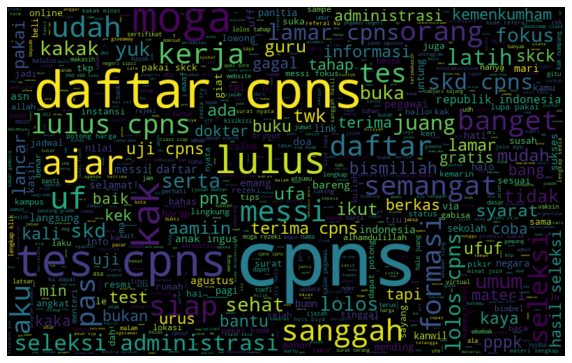

In [93]:
pos_word =  ' '.join(text for text in df[df['sentimen']=='positif'].tweet)
#usa = " ".join(review for review in df[df["country"]=="US"].description)

wordcloud = WordCloud(width=800,max_words=2000, height=500, random_state=21, max_font_size=110).generate(pos_word)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


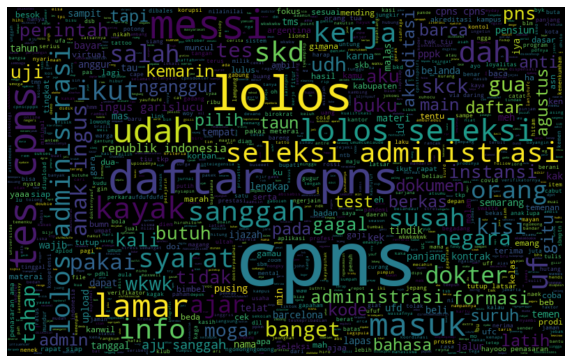

In [94]:
neg_word =  ' '.join(text for text in df[df['sentimen']=='negatif'].tweet)
#usa = " ".join(review for review in df[df["country"]=="US"].description)

wordcloud = WordCloud(width=800,max_words=2000, height=500, random_state=21, max_font_size=110).generate(neg_word)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


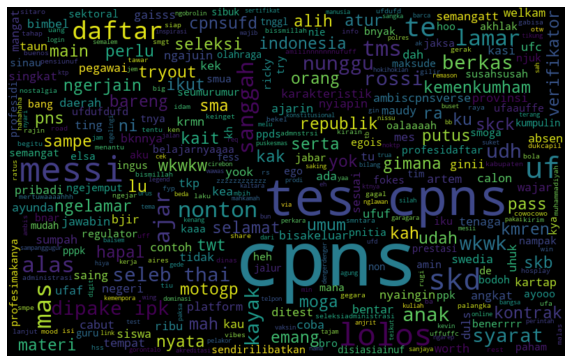

In [95]:
net_word =  ' '.join(text for text in df[df['sentimen']=='netral'].tweet)
#usa = " ".join(review for review in df[df["country"]=="US"].description)

wordcloud = WordCloud(width=800,max_words=2000, height=500, random_state=21, max_font_size=110).generate(net_word)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [96]:
wordcloud.to_file("wordcloud.png")